In [1]:
import bempp.api
import numpy as np

import sys
sys.path.append('../../')
from decimal import *

import bemppUQ
from bemppUQ.operators.maxwell import assemble_operators, evaluate_far_field, evaluate_far_field_sd

bempp.api.global_parameters.assembly.potential_operator_assembly_type = 'dense'
bempp.api.global_parameters.hmat.eps = 1E-4


from bemppUQ.shapes import reentrant_cube_exterior

def function(x, y, i, j):
    zx = 0
    zy = 0
    if i == 0:
        zx = np.sin(x * np.pi * 2)
    if i == 1:
        if x <= 0.25:
            zx = np.sin(x * np.pi * 4)
    if i == 2:
        if x > 0.25:
            zx = -np.sin(x * np.pi * 4)
    if i == 3:
        if x <= 0.5 / 3.:
            zx = np.sin(x * np.pi * 6)
    if i == 4:
        if x > 0.5 / 3. and x <= 1 / 3.:
            zx = -np.sin(x * np.pi * 6)
    if i ==5:
        if x > 1/3.:
            zx = np.sin(x * np.pi * 6)

    if j == 0:
        zy = np.sin(y * np.pi * 2)

    if j == 1:
        if y <= 0.25:
            zy = np.sin(y * np.pi * 4)

    if j == 2:
        if y > 0.25:
            zy = -np.sin(y * np.pi * 4)
    
    if j == 3:
        if y <= 0.5 / 3.:
            zy = np.sin(y * np.pi * 6)

    if j == 4:
        if y > 0.5 / 3. and y <= 1 / 3.:
            zy = -np.sin(y * np.pi * 6)
    if j == 5:
        if y > 1/3.:
            zy = np.sin(y * np.pi * 6)

    return zx * zy


# Def random:

def Phiz(point, n, domain_index, result):
    x, y, z = point

    res = 0j
    if z == 0.5 and (x <= 0.5) and (y <= 0.5):
        for ii in range(6):
            for jj in range(6):
                res += Random[ii,jj] * function(x, y, ii,jj)	
    result[0] = res



def perturbate(grid, t, kappa_pert=None):
    P1 = bempp.api.function_space(grid, 'B-P', 1)
    grid_funz = bempp.api.GridFunction(P1, fun = Phiz)
    elements = grid.leaf_view.elements
    vertices = grid.leaf_view.vertices
    normals = P1.global_dof_normals
    x, y, z = vertices
    
    vertices[2, :] = z + t * grid_funz.coefficients
    return bempp.api.grid_from_element_data(vertices, elements)


def get_base_grid(h):

    gr0 = bempp.api.shapes.reentrant_cube(h=h, refinement_factor=1) 
    elements0 = list(gr0.leaf_view.entity_iterator(0))
    N0 = len(elements0)
    tol = h / 10.
    for i in range(N0):
        el0 = elements0[i]
        z = el0.geometry.corners[2]
        if np.linalg.norm(np.array([1/2, 1/2, 1/2]) - z) < tol:
            gr0.mark(el0)
    gr1 = gr0.refine()


    elements0 = list(gr1.leaf_view.entity_iterator(0))
    N0 = len(elements0)
    for i in range(N0):
        el0 = elements0[i]
        z = el0.geometry.corners[2]
        if np.linalg.norm(np.array([1/2, 1/2, 1/2])-z) < tol:
            gr1.mark(el0)

    base_grid = gr1.refine()
    return base_grid


config = bemppUQ.config.set_case('A')
precision = 10

h = 2.0 * np.pi / (precision * config["k_int"])

base_grid = get_base_grid(h=h) 
print(base_grid.leaf_view.entity_count(1) * 2)

transmission_operators = assemble_operators(base_grid, config)
Umean0, solution = evaluate_far_field(transmission_operators, config)


In [ ]:
M = 20
t = .05


solt = []

for i in range(M):
    print('percentage:= ', i  / M * 100)
    Random = np.random.rand(6,6) * 2  - 1
    gridt = perturbate(base_grid, t)
    
    transmission_operators_t = assemble_operators(gridt, config)
    Ut, _ = evaluate_far_field(transmission_operators_t, config)
    
    solt.append(Ut)

Umean = np.sum(np.array(solt), axis = 0) / M

vart = []
for i in range(M):
    vart.append( (solt[i] - Umean) *np.conj(solt[i] - Umean) )



Uvar = np.sum(np.array(vart), axis=0) / M

Umean = np.sum(Umean, axis=0)
Uvar = np.sum(Uvar, axis=0)


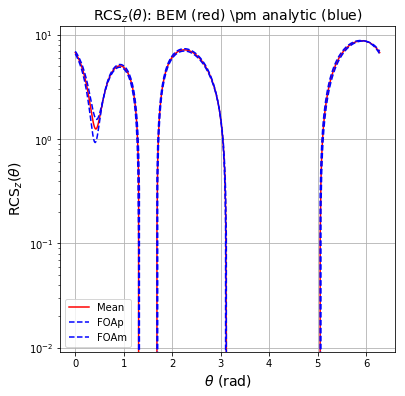

In [5]:
from matplotlib import pyplot as plt
from bemppUQ.utils.login import tensorize

fig, ax  = plt.subplots(1,1, figsize=(6,6))

FFp = Umean  + np.sqrt(np.abs(Uvar))
FFm = Umean  - np.sqrt(np.abs(Uvar))

angles = config['angles']

cs = 10 * np.log10(4 * np.pi * np.abs(Umean)**2)
cs_FOAp = 10 * np.log10(4 * np.pi * np.abs(FFp)**2)
cs_FOAm = 10 * np.log10(4 * np.pi * np.abs(FFm)**2)


ax.semilogy(angles, cs, '-r', label='Mean')
ax.semilogy(angles,cs_FOAp, '--b', label='FOAp')
ax.semilogy(angles,cs_FOAm, '--b', label='FOAm')

ax.set_title(r'$\mathrm{RCS}_z(\theta)$: BEM (red) \pm analytic (blue)', fontsize=14)

ax.set_xlabel(r'$\theta$ (rad)', fontsize=14)
ax.set_ylabel(r'$\mathrm{RCS}_z(\theta)$', fontsize=14)

ax.legend()
ax.grid()


In [13]:
Umean

array([ 0.42148017+0.44746578j,  0.43176971+0.41920752j,
        0.44040188+0.39046569j,  0.44737475+0.3613377j ,
        0.45269311+0.33191939j,  0.45636823+0.30230471j,
        0.45841764+0.27258525j,  0.45886483+0.24284993j,
        0.45773897+0.21318462j,  0.45507463+0.18367188j,
        0.45091138+0.1543907j ,  0.44529353+0.12541621j,
        0.43826974+0.09681952j,  0.42989271+0.06866757j,
        0.42021876+0.04102291j,  0.40930752+0.01394367j,
        0.39722157-0.01251654j,  0.38402605-0.0383087j ,
        0.36978836-0.06338838j,  0.35457777-0.08771574j,
        0.3384651 -0.11125548j,  0.32152238-0.13397683j,
        0.30382257-0.1558534j ,  0.28543918-0.17686312j,
        0.26644607-0.19698814j,  0.24691708-0.21621463j,
        0.22692581-0.23453267j,  0.20654536-0.25193604j,
        0.18584809-0.26842209j,  0.16490537-0.28399148j,
        0.14378743-0.298648j  ,  0.12256309-0.31239836j,
        0.10129965-0.32525198j,  0.08006267-0.33722071j,
        0.05891586-0.34831864j,

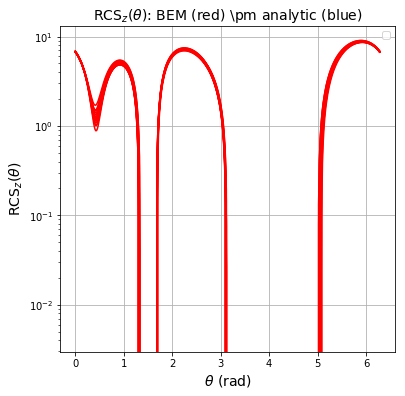

In [6]:
from matplotlib import pyplot as plt
from bemppUQ.utils.login import tensorize

fig, ax  = plt.subplots(1,1, figsize=(6,6))

angles = config['angles']

for m in range(M):
    Ut = solt[m]
    Ut = np.sum(Ut, axis=0)
    
    ct = 10 * np.log10(4 * np.pi * np.abs(Ut)**2)
    
    ax.semilogy(angles, ct, '-r')

ax.set_title(r'$\mathrm{RCS}_z(\theta)$: BEM (red) \pm analytic (blue)', fontsize=14)

ax.set_xlabel(r'$\theta$ (rad)', fontsize=14)
ax.set_ylabel(r'$\mathrm{RCS}_z(\theta)$', fontsize=14)

ax.legend()
ax.grid()

In [10]:
cs.max()

8.782738980127059